# Chapter 3 – Classification
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alirezatheh/handson-ml3-notes/blob/main/notebooks/03_classification.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/alirezatheh/handson-ml3-notes/blob/main/notebooks/03_classification.ipynb)

## MNIST
We use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. This set is often called the “hello world” of machine learning. Let's download it from OpenML.org:

**Note**: Scikit-Learn caches downloaded datasets in a directory called `scikit_learn_data` in our home directory.

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

`sklearn.datasets` contains three types of functions:
- `fetch_*`: To download real-life datasets
- `load_*`: To load small toy datasets bundled with Scikit-Learn
- `make_*`: To generate fake datasets, useful for tests

Generated datasets are usually returned as an `(X, y)` tuple both as NumPy arrays. Others are returned as `sklearn.utils.Bunch` objects, which are dictionaries whose entries can also be accessed as attributes. They generally contain the following entries:
- `'DESCR'`: A description of the dataset
- `'data'`: The input data, usually as a 2D NumPy array
- `'target'`: The labels, usually as a 1D NumPy array

The `fetch_openml()` function is a bit unusual since by default it returns the inputs as a Pandas DataFrame and the labels as a Pandas Series (unless the dataset is sparse).

In [2]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
# We only use data and target in this notebook
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

In [8]:
28 * 28

784

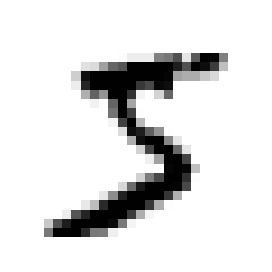

In [9]:
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


def plot_digit(image_data: ArrayLike) -> None:
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')


some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [10]:
y[0]

'5'

The MNIST dataset returned by `fetch_openml()` is actually already shuffled and split into a training set and a test set, because some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.

**Warning**: Datasets returned by `fetch_openml()` are not always shuffled or split.

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Let’s simplify the problem for now and only try to identify one digit:

In [12]:
# True for all 5s, False for all other digits
y_train_5 = y_train == '5'
y_test_5 = y_test == '5'

Let's train a classifier using `SGDClassifier` (stochastic gradient descent or
stochastic GD):

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Above 95% accuracy? Don't get too excited.

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

<div style="border: 1px solid;">

#### Implementing Cross-Validation
Let's implement cross-validation ourselves:
</div>

In [18]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# Add shuffle=True if the dataset is not already shuffled
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


### Confusion Matrix
The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. e.g. to know the number of times the classifier confused images of 8s with 0s, we would look at row #8, column #0 of the confusion matrix.

To compute the confusion matrix, we first need a set of predictions. we use the `cross_val_predict()` function:

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

It's like the `cross_val_score()`, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that we get a clean prediction for each instance in the training set (by “clean” I mean “out-of-sample”: the model makes predictions on data that it never saw during training).

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

- Each row: *Actucal class*
- Each column: *Predicted class*

- `53892`: *true negatives*
- `687`: *false positives* (*type I errors*)
- `1891`: *false negatives* (*type II errors*)
- `3530`: *true positives*

In [21]:
# Pretend we reached perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Another metric is the accuracy of the positive predictions and called the *precision* of the classifier.

**Equation 3-1** Precision
$$
\text{precision}=\frac{TP}{TP+FP}
$$

Precision is typically used along with another metric. The ratio of positive instances that are correctly detected by the classifier is called *recall* or *sensitivity* or the *true positive rate* (TPR).

**Equation 3-2** Recall
$$
\text{recall}=\frac{TP}{TP+FN}
$$

Confused about the confusion matrix? Look the figure below:

<center>
  <img 
    src="../images/03/illustrated_confusion_matrix.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

### Precision and Recall

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

So when it claims an image represents a 5 it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

$F_1$ *score* is the harmonic mean of precision and recall which gives much more weight to low values.

**Equation 3-3** $F_1$ score
$$
F_1=\frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}
=2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}}
=\frac{TP}{TP+\frac{FN+FP}{2}}
$$

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what we want:
- If we want to train a classifier to detect videos that are safe for kids, we prefer it to reject many good videos (low recall) but keeps only safe ones (high precision), we may even want to add a human pipeline to check the classifier’s video selection.
- If we train a classifier to detect shoplifters in surveillance images, it is fine if it only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

We can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*.

### Precision/Recall Trade-off
Let’s look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. The figure below shows a few digits positioned from the lowest score on the left to the highest score on the right and  *decision thresholds* positioned using arrows:

<a id="precision-recall-trade-off-figure"></a>
<center>
  <img 
    src="../images/03/precision_recall_trade_off.png"
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = y_scores > threshold

In [27]:
y_some_digit_pred

array([ True])

The `SGDClassifier` uses a threshold equal to 0. Let’s raise the threshold:

In [28]:
threshold = 3000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall.

How do we decide which threshold to use?

In [29]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method='decision_function'
)

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

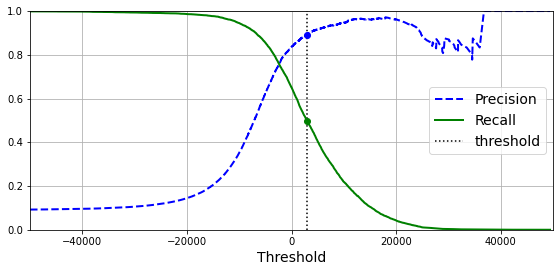

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')

# This section just beautifies figure
# First index ≥ threshold
idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel('Threshold')
plt.legend(loc='center right')

plt.show()

**Note**: We may wonder why the precision curve is bumpier than the recall curve in. The reason is that precision may sometimes go down when we raise the threshold (although in general it will go up). To understand why, look back at [this figure](#precision-recall-trade-off-figure) and notice what happens when we start from the central threshold and move it just one digit to the right: precision goes from 4/5 (80%) down to 3/4 (75%). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Another way is to plot precision directly against recall:

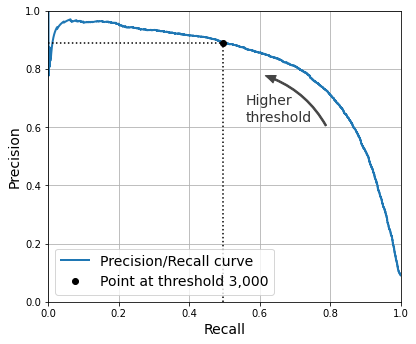

In [32]:
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')

# This section just beautifies figure
plt.plot([recalls[idx], recalls[idx]], [0.0, precisions[idx]], 'k:')
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot(
    [recalls[idx]], [precisions[idx]], 'ko', label='Point at threshold 3,000'
)
plt.gca().add_patch(
    patches.FancyArrowPatch(
        (0.79, 0.60),
        (0.61, 0.78),
        connectionstyle='arc3,rad=.2',
        arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
        color='#444444',
    ),
)
plt.text(0.56, 0.62, 'Higher\nthreshold', color='#333333')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower left')
plt.show()

Alternatively, we can search for the lowest threshold that gives us at least 90% precision. For this, we can use the NumPy array’s `argmax()` method.

In [33]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [34]:
# Making predictions
y_train_pred_90 = y_scores >= threshold_for_90_precision

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

**Tip**: If someone says, “Let’s reach 99% precision”, we should ask, “At what recall?”

### The ROC Curve
The *receiver operating characteristic* (ROC) curve, plots the *true positive rate* (another name for recall) against the *false positive rate* (FPR). The FPR (also called the *fall-out*) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the *true negative rate* (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence, the ROC curve plots *sensitivity* (recall) versus 1 – *specificity*.

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

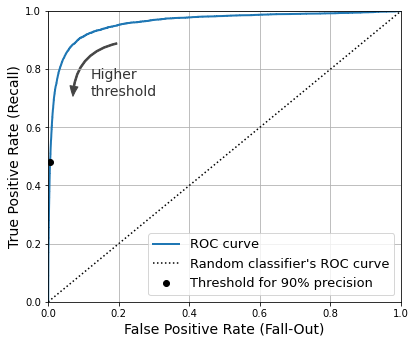

In [38]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label='Random classifier\'s ROC curve')
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')

# This section just beautifies figure
plt.gca().add_patch(
    patches.FancyArrowPatch(
        (0.20, 0.89),
        (0.07, 0.70),
        connectionstyle='arc3,rad=.4',
        arrowstyle='Simple, tail_width=1.5, head_width=8, head_length=10',
        color='#444444',
    ),
)
plt.text(0.12, 0.71, 'Higher\nthreshold', color='#333333')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower right', fontsize=13)
plt.show()

Once again there is a trade-off. One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Tip**: How to choose between ROC and PR curve? As a rule of thumb, we should prefer the PR curve whenever the positive class is rare or when we care more about the false positives than the false negatives. Otherwise, use the ROC curve.

**Note**: Scikit-Learn classifiers always have either a `decision_function()` method or a `predict_proba()` method, or sometimes both.

**Warning**: Probabilities returned by the `predict_proba()` are *estimated* probabilities, not actual probabilities. The `sklearn.calibration` package contains tools to calibrate the estimated probabilities and make them much closer to actual probabilities.

## Multiclass Classification
Whereas binary classifiers distinguish between two classes, *multiclass classifiers* (also called *multinomial classifiers*) can distinguish between more than two classes.

Scikit-Learn classifiers capable of handling multiple classes natively:
- `LogisticRegression`
- `RandomForestClassifier`
- `GaussianNB`

Strictly binary classifiers
- `SGDClassifier`
- `SVC`

There are strategies to perform multiclass classification with multiple binary classifiers. e.g. to classify the digit images into 10 classes:
- Train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then select the class whose classifier outputs the highest score. This is called the *one-versus-the-rest* (OvR) strategy, or sometimes *one-versus-all* (OvA).
- Train a binary classifier for every pair of digits. Run the image through all $N\times(N-1)/2$ classifiers and see which class wins the most duels. This is called the *one-versus-one* (OvO) strategy. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish. For algorithms that scale poorly with the size of the training set (e.g. SVC), OvO is preferred.

Scikit-Learn will automatically do this for us:

In [40]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
# y_train, not y_train_5
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [41]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])
# Number of won duels
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [43]:
class_id = some_digit_scores.argmax()
class_id

5

In [44]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [45]:
svm_clf.classes_[class_id]

'5'

If we want `decision_function()` to return all 45 scores, we can set the `decision_function_shape` hyperparameter to `'ovo'`. The default value is `'ovr'`, but don't let this confuse us: `SVC` always uses OvO for training. This hyperparameter only affects whether the 45 scores get aggregated or not:

In [46]:
# Shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = 'ovo'
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

If we want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, we can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes.

In [47]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [48]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [49]:
len(ovr_clf.estimators_)

10

In [50]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

This time Scikit-Learn used the OvR strategy.

In [51]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

**Warning:**: The following two cells may take a few minutes each to run.

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis
We will assume that we have found a promising model, and we want to improve it. One way to do this is to analyze the types of errors it makes.

Let's plot a colored diagram of the confusion matrix:

**Warning:** the following cell will take a few minutes to run.

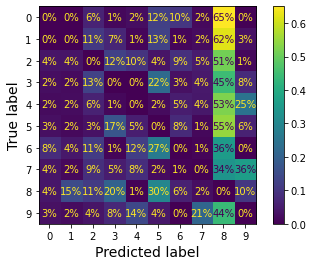

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
sample_weight = y_train_pred != y_train
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    # Putting zero weights on correct predictions
    sample_weight=sample_weight,
    # Divide by row sum
    normalize='true',
    # Shows percentages with no decimal
    values_format='.0%',
)
plt.show()

We see that the column for class 8 is now really bright, which confirms that many images got misclassified as 8s. We could try to gather more training data for digits that look like 8s (but are not).

**Tip**: It is also possible to normalize the confusion matrix by column rather than by row by setting `normalize='pred'`.

Analyzing individual errors can also be a good way to gain insights into what the classifier is doing and why it is failing. e.g. let’s plot examples of 3s and 5s in a confusion matrix style:

In [55]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

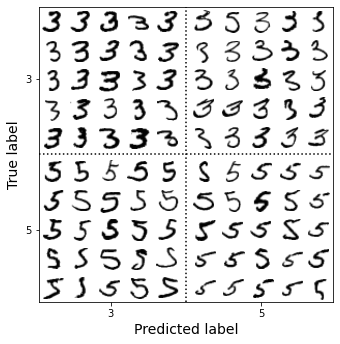

In [56]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [
    (X_ba, (0, 0)),
    (X_bb, (1, 0)),
    (X_aa, (0, 1)),
    (X_ab, (1, 1)),
]:
    for idx, image_data in enumerate(images[: size * size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(
            image_data.reshape(28, 28),
            cmap='binary',
            extent=(x, x + 1, y, y + 1),
        )
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], 'k:')
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], 'k:')
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Some of the digits that the classifier gets wrong are so badly written that even a human would have trouble classifying them. However, most misclassified images seem like obvious errors to us. Since 5 and 3 are very similar we can try a more complex model or *data augmentation*.

**Tip**: There are several other ways we could code a plot like this one, but it's a bit hard to get the axis labels right:
- Using [nested GridSpecs](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html)
- Merging all the digits in each block into a single image (then using 2×2 subplots). e.g.:
  ```python
  X_aa[:25].reshape(5, 5, 28, 28).transpose(0, 2, 1, 3).reshape(5 * 28, 5 * 28)
  ```
- Using [subfigures](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) (since Matplotlib 3.4)

## Multilabel Classification
A classification system that outputs multiple binary tags is called a *multilabel classification* system.

In [57]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= '7'
y_train_odd = y_train.astype('int8') % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

To evaluate the model we can measure $F_1$ score for each label and the compute the average:

**Warning**: the following cell may take a few minutes to run.

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

If all labels are not equally important, we can give each label a weight equal to its *support* (i.e., the number of instances with that target label).

In [60]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

For classifiers that does not natively support multilabel classification (e.g. SVC), one possible strategy is to train one model per label. However, this strategy is not good capturing the dependencies between the labels. Other strategy is to use a chain: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain.

With `cv` hyperparameter, we get “clean” (out-of-sample) predictions from each trained model for every instance in the training set, and these predictions will then be used to train all the models later in the chain.

In [61]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [62]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification
It is a generalization of multilabel classification where each label can be multiclass. (i.e., it can have more than two possible values). It's also called *multioutput–multiclass classification*.

In [63]:
# To make this code example reproducible
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

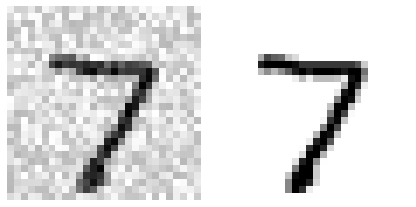

In [64]:
plt.subplot(121)
plot_digit(X_test_mod[0])
plt.subplot(122)
plot_digit(y_test_mod[0])
plt.show()

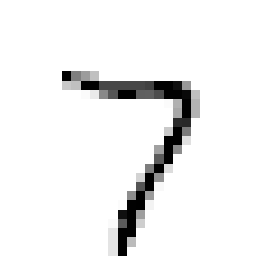

In [65]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

## Exercises

### 1.
Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; we just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters).
> Let's start with a simple K-Nearest Neighbors classifier and measure its performance on the test set. This will be our baseline:

In [66]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

> Great! A regular KNN classifier with the default hyperparameters is already very close to our goal. Let's see if tuning the hyperparameters can help. To speed up the search, let's train only on the first 10,000 images:

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6]}
]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [68]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [69]:
grid_search.best_score_

0.9441999999999998

> The score dropped, but that was expected since we only trained on 10,000 images. So let's take the best model and train it again on the full training set:

In [70]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

> We reached our goal of 97% accuracy! 🥳

### 2. 
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. We can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train our best model on this expanded training set and measure its accuracy on the test set. We should observe that our model performs even better now! This technique of artificially growing the training set is called *data augmentation* or *training set expansion*.
> Let's try augmenting the MNIST dataset by adding slightly shifted versions of each image.

In [71]:
from scipy.ndimage import shift

In [72]:
def shift_image(image: ArrayLike, dx: int, dy: int) -> ArrayLike:
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

> Let's see if it works:

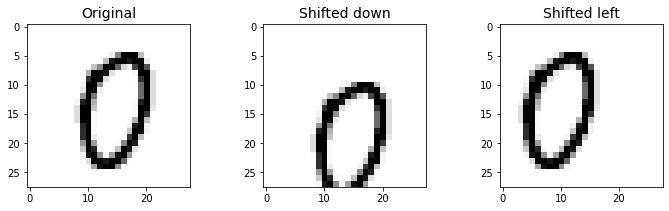

In [73]:
# Some random digit to demo
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Original')
plt.imshow(image.reshape(28, 28), interpolation='nearest', cmap='Greys')
plt.subplot(132)
plt.title('Shifted down')
plt.imshow(
    shifted_image_down.reshape(28, 28), interpolation='nearest', cmap='Greys'
)
plt.subplot(133)
plt.title('Shifted left')
plt.imshow(
    shifted_image_left.reshape(28, 28), interpolation='nearest', cmap='Greys'
)
plt.show()

> Looks good! Now let's create an augmented training set by shifting every image left, right, up and down by one pixel:

In [74]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

> Let's shuffle the augmented training set, or else all shifted images will be grouped together:

In [75]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

> Now let's train the model using the best hyperparameters we found in the previous exercise:

In [76]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [77]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

> **Warning**: the following cell may take a few minutes to run.

In [78]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

> By simply augmenting the data, we've got a 0.5% accuracy boost. Perhaps it does not sound so impressive, but it actually means that the error rate dropped significantly:

In [79]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f'error_rate_change = {error_rate_change:.0%}')

error_rate_change = -17%


> The error rate dropped quite a bit thanks to data augmentation.

### 3. 
Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, we can download the data from https://homl.info/titanic.tgz and unzip this tarball like we did for the housing data in Chapter 2. This will give us two CSV files: *train.csv* and *test.csv* which we can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns.
> Let's fetch the data and load it:

In [80]:
import tarfile
import urllib.request
from pathlib import Path
from typing import List

import pandas as pd


def load_titanic_data() -> List[pd.DataFrame]:
    tarball_path = Path('datasets/titanic.tgz')
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/titanic.tgz'
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path='datasets')
    return [
        pd.read_csv(Path('datasets/titanic') / filename)
        for filename in ('train.csv', 'test.csv')
    ]

In [81]:
train_data, test_data = load_titanic_data()

> The data is already split into a training set and a test set. However, the test data does *not* contain the labels: our goal is to train the best model we can on the training data, then make our predictions on the test data and upload them to Kaggle to see our final score.

> Let's take a peek at the top few rows of the training set:

In [82]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


> The attributes have the following meaning:
> - **PassengerId**: A unique identifier for each passenger
> - **Survived**: That's the target, 0 means the passenger did not survive, while 1 means he/she survived.
> - **Pclass**: Passenger class.
> - **Name**, **Sex**, **Age**: Self-explanatory
> - **SibSp**: How many siblings & spouses of the passenger aboard the Titanic.
> - **Parch**: How many children & parents of the passenger aboard the Titanic.
> - **Ticket**: Ticket id
> - **Fare**: Price paid (in pounds)
> - **Cabin**: Passenger's cabin number
> - **Embarked**: Where the passenger embarked the Titanic

> The goal is to predict whether a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on or not.

> Let's explicitly set the `PassengerId` column as the index column:

In [83]:
train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')

> Let's get more info to see how much data is missing:

In [84]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [85]:
train_data[train_data['Sex'] == 'female']['Age'].median()

27.0

> Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

> The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

> Let's take a look at the numerical attributes:

In [86]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


> - Yikes, only 38% **Survived**! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
> - The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
> - The mean **Age** was less than 30 years old.

> Let's check that the target is indeed 0 or 1:

In [87]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

> Now let's take a quick look at all the categorical attributes:

In [88]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [89]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [90]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

> The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

> Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [91]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)

> Now we can build the pipeline for the categorical attributes:

In [92]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [93]:
cat_pipeline = Pipeline(
    [
        ('ordinal_encoder', OrdinalEncoder()),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse_output=False)),
    ]
)

> Finally, let's join the numerical and categorical pipelines:

In [94]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer(
    [
        ('num', num_pipeline, num_attribs),
        ('cat', cat_pipeline, cat_attribs),
    ]
)

> Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [95]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

> Let's not forget to get the labels:

In [96]:
y_train = train_data['Survived']

> We are now ready to train a classifier. Let's start with a `RandomForestClassifier`:

In [97]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

> Great, our model is trained, let's use it to make predictions on the test set:

In [98]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

> And now we could just build a CSV file with these predictions (respecting the format expected by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [99]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

> Okay, not too bad! Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, we can see that our score is in the top 2%, woohoo! Some Kagglers reached 100% accuracy, but since we can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! 😆

> Let's try an `SVC`:

In [100]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

> Great! This model looks better.

> But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR=Q_3-Q_1$ (this is the box's height), and any score lower than $Q_1-1.5\times IQR$ is a flier, and so is any score greater than $Q_3+1.5\times IQR$.

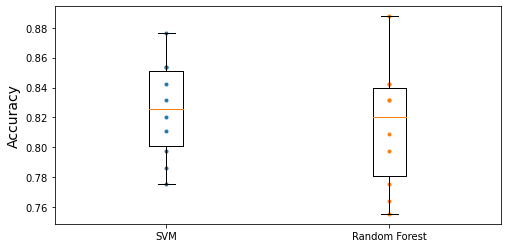

In [101]:
plt.figure(figsize=(8, 4))
plt.plot([1] * 10, svm_scores, '.')
plt.plot([2] * 10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy')
plt.show()

> The random forest classifier got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the SVM classifier is more likely to generalize well.

> To improve this result further, we could:
> - Compare many more models and tune hyperparameters using cross validation and grid search,
> - Do more feature engineering, e.g.:
>   - Try to convert numerical attributes to categorical attributes: e.g. different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
>   - Replace **SibSp** and **Parch** with their sum.
>   - Try to identify parts of names that correlate well with the **Survived** attribute.
>   - Use the **Cabin** column, for example take its first letter and treat it as a categorical attribute.

In [102]:
train_data['AgeBucket'] = train_data['Age'] // 15 * 15
train_data[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [103]:
train_data['RelativesOnboard'] = train_data['SibSp'] + train_data['Parch']
train_data[['RelativesOnboard', 'Survived']].groupby(
    ['RelativesOnboard']
).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


### 4.
Build a spam classifier (a more challenging exercise):
- **a.** Download examples of spam and ham from [Apache SpamAssassin's public datasets](https://homl.info/spamassassin).
- **b.** Unzip the datasets and familiarize ourselves with the data format.
- **c.** Split the datasets into a training set and a test set.
- **d.** Write a data preparation pipeline to convert each email into a feature vector. Our preparation pipeline should transform an email into a (sparse vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, "Hello", "how", "are", "you", then the email "Hello you Hello Hello you" would be converted into a vector [1, 0, 0, 1] (meaning [“Hello" is present, "how" is absent, "are is absent, "you" is present]), or [3, 0, 0, 2] if we prefer to count the number of occurrences of each word. We may want to add hyperparameters to our preparation pipeline to control whether to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with "URL", replace all numbers with "NUMBER", or even perform *stemming* (i.e., trim off word endings; there are Python libraries available to do this) or not.
- **e.** Finally, try out several classifiers and see if we can build a great spam classifier, with both high recall and high precision.

In [104]:
def fetch_spam_data() -> List[Path]:
    spam_root = 'http://spamassassin.apache.org/old/publiccorpus/'
    ham_url = spam_root + '20030228_easy_ham.tar.bz2'
    spam_url = spam_root + '20030228_spam.tar.bz2'

    spam_path = Path() / 'datasets' / 'spam'
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (
        ('easy_ham', 'ham', ham_url),
        ('spam', 'spam', spam_url),
    ):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix('.tar.bz2')
            print('Downloading', path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ('easy_ham', 'spam')]

In [105]:
ham_dir, spam_dir = fetch_spam_data()

> Next, let's load all the emails:

In [106]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [107]:
len(ham_filenames)

2500

In [108]:
len(spam_filenames)

500

> We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [109]:
import email
import email.policy


def load_email(filepath: Path) -> email.message.EmailMessage:
    with open(filepath, 'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [110]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

> Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [111]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [112]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


> Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [113]:
def get_email_structure(email: email.message.EmailMessage) -> str:
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ', '.join(
            [get_email_structure(sub_email) for sub_email in payload]
        )
        return f'multipart({multipart})'
    else:
        return email.get_content_type()

In [114]:
from collections import Counter


def structures_counter(emails: List[email.message.EmailMessge]) -> Counter:
    structures = Counter()
    for e in emails:
        structure = get_email_structure(e)
        structures[structure] += 1
    return structures

In [115]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [116]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

> It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP while no spam is. In short, it seems that the email structure is useful information to have.

> Now let's take a look at the email headers:

In [117]:
for header, value in spam_emails[0].items():
    print(header, ':', value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

> There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [118]:
spam_emails[0]['Subject']

'Life Insurance - Why Pay More?'

> Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [119]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

> Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [120]:
import re
from html import unescape


def html_to_plain_text(html: str) -> str:
    text = re.sub(r'<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub(r'<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub(r'<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

> Let's see if it works. This is HTML spam:

In [121]:
html_spam_emails = [
    email
    for email in X_train[y_train == 1]
    if get_email_structure(email) == 'text/html'
]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], '...')

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

> And this is the resulting plain text:

In [122]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

> Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [123]:
def email_to_text(email: email.EmailMessage) -> str:
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if ctype not in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        # In case of encoding issues
        except Exception:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [124]:
print(email_to_text(sample_html_spam)[:100], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


> Let's throw in some stemming! We will use the Natural Language Toolkit ([NLTK](http://www.nltk.org/)):

In [125]:
import nltk

stemmer = nltk.PorterStemmer()
for word in (
    'Computations',
    'Computation',
    'Computing',
    'Computed',
    'Compute',
    'Compulsive',
):
    print(word, '=>', stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


> We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library:

In [126]:
import sys

# Is this notebook running on Colab or Kaggle?
IS_COLAB = 'google.colab' in sys.modules
IS_KAGGLE = 'kaggle_secrets' in sys.modules

# If running this notebook on Colab or Kaggle, we just pip install
# urlextract
if IS_COLAB or IS_KAGGLE:
    %pip install urlextract

> **Note**: Inside a Jupyter notebook, always use `%pip` instead of `!pip`, as `!pip` may install the library inside the wrong environment, while `%pip` makes sure it's installed inside the currently running environment.

In [127]:
# May require an Internet connection to download root domain names
import urlextract

url_extractor = urlextract.URLExtract()
some_text = 'Will it detect github.com https://youtu.be/7Pq-S557XQU?t=3m32s'
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


> We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. e.g. Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [128]:
from typing import Optional

from sklearn.base import BaseEstimator, TransformerMixin
from typing_extensions import Self


class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        strip_headers: bool = True,
        lower_case: bool = True,
        remove_punctuation: bool = True,
        replace_urls: bool = True,
        replace_numbers: bool = True,
        stemming: bool = True,
    ) -> None:
        self.strip_headers: bool = strip_headers
        self.lower_case: bool = lower_case
        self.remove_punctuation: bool = remove_punctuation
        self.replace_urls: bool = replace_urls
        self.replace_numbers: bool = replace_numbers
        self.stemming: bool = stemming

    def fit(self, X: ArrayLike, y: Optional[ArrayLike] = None) -> Self:
        return self

    def transform(
        self, X: ArrayLike, y: Optional[ArrayLike] = None
    ) -> ArrayLike:
        X_transformed = []
        for e in X:
            text = email_to_text(e) or ''
            if self.lower_case:
                text = text.lower()

            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, ' URL ')

            if self.replace_numbers:
                text = re.sub(
                    r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text
                )

            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)

            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)

        return np.array(X_transformed)

> Let's try this transformer on a few emails:

In [129]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

> This looks about right!

> Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [130]:
from scipy.sparse import csr_matrix


class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size: int = 1000) -> None:
        self.vocabulary_size = vocabulary_size

    def fit(self, X: ArrayLike, y: Optional[ArrayLike] = None) -> Self:
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[: self.vocabulary_size]
        self.vocabulary_ = {
            word: index + 1 for index, (word, count) in enumerate(most_common)
        }
        return self

    def transform(
        self, X: ArrayLike, y: Optional[ArrayLike] = None
    ) -> csr_matrix:
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix(
            (data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1)
        )

In [131]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [132]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

> What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. We can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of" etc.

In [133]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

> We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [134]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline(
    [
        ('email_to_wordcount', EmailToWordCounterTransformer()),
        ('wordcount_to_vector', WordCounterToVectorTransformer()),
    ]
)

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.985

> Over 98.5%, not bad for a first try! :) However, remember that we are using the "easy" dataset. We can try with the harder datasets, the results won't be so amazing. We would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

> But we get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [136]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f'Precision: {precision_score(y_test, y_pred):.2%}')
print(f'Recall: {recall_score(y_test, y_pred):.2%}')

Precision: 96.88%
Recall: 97.89%
